Todo:<br>
stratify sampling<br>
~PCA~<br>
check time dependent info<br>
if feature sparse<br>
cross validation<br>

# Colab Setting


In [ ]:
import os
from google.colab import drive
# mount Google drive
drive.mount('/content/drive')


# by default everything gets executed and saved in 'Berkeley Capstone (Students)'
# notebook_path = '/content/drive/MyDrive/Berkeley Capstone (Students)/Code' # WK
# notebook_path = '/content/drive/MyDrive/Capstone/Berkeley Capstone (Students)/Code/InsDetek3.0_LSTM' # GQ
notebook_path = '/content/drive/MyDrive/1 UC Berkeley/Capstone/Berkeley Capstone/Code/InsDetek3.0_LSTM' # NA
os.chdir(notebook_path)

# !echo -e "\nCurrent directory:"
# !pwd

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange
from collections import defaultdict
import matplotlib.pyplot as plt
import time
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from dataloader_ import df_to_tensor
import re

# Read Data

In [ ]:
# df = pd.read_csv('data/week_norm_all.csv') # Norm
# df = pd.read_csv('data/week_norm_pca.csv') # Norm, PCA
# df = pd.read_csv('week_norm_pca_70.csv') # Norm, PCA, Delted 70% clean(72,0)
df = pd.read_csv('data/data_3.1.csv', index_col='idx').drop('week', axis=1)
df.head()

,user,n_allact,allact_n-pc0,allact_n-pc1,allact_n-pc2,allact_n-pc3,n_workhourallact,workhourallact_n-pc0,workhourallact_n-pc1,workhourallact_n-pc2,...,weekendhttp_jobf_mean_http_c_len,weekendhttp_jobf_mean_http_c_nwords,weekendhttp_jobf_n-pc0,weekendhttp_n_leakf,weekendhttp_leakf_mean_url_len,weekendhttp_leakf_mean_url_depth,weekendhttp_leakf_mean_http_c_len,weekendhttp_leakf_mean_http_c_nwords,weekendhttp_leakf_n-pc0,insider
idx,,,,,,,,,,,,,,,,,,,,,
17822,4.0,-1.413080,-1.403029,-0.164752,-0.162994,-0.043623,-1.368535,-1.356573,-0.155259,-0.076973,...,-0.064855,-0.06509,-0.043475,-0.043138,-0.043138,-0.043138,-0.041869,-0.041897,-0.043138,0
18801,4.0,-1.409682,-1.399599,-0.164752,-0.162994,-0.043623,-1.357743,-1.345797,-0.155259,-0.076973,...,-0.064855,-0.06509,-0.043475,-0.043138,-0.043138,-0.043138,-0.041869,-0.041897,-0.043138,0
19777,4.0,-1.409682,-1.399599,-0.164752,-0.162994,-0.043623,-1.357743,-1.345797,-0.155259,-0.076973,...,-0.064855,-0.06509,-0.043475,-0.043138,-0.043138,-0.043138,-0.041869,-0.041897,-0.043138,0
20752,4.0,-1.457248,-1.447616,-0.164752,-0.162994,-0.043623,-1.411703,-1.399677,-0.155259,-0.076973,...,-0.064855,-0.06509,-0.043475,-0.043138,-0.043138,-0.043138,-0.041869,-0.041897,-0.043138,0
21727,4.0,-1.409682,-1.399599,-0.164752,-0.162994,-0.043623,-1.357743,-1.345797,-0.155259,-0.076973,...,-0.064855,-0.06509,-0.043475,-0.043138,-0.043138,-0.043138,-0.041869,-0.041897,-0.043138,0


In [ ]:
df['insider'].sum()

2902

In [ ]:
df.shape # 180 features, 1 'user', 1 label

(19381, 405)

In [ ]:
train, test = train_test_split(df, train_size = 0.8, shuffle = True)
valid, test = train_test_split(test, train_size = 0.2, shuffle = True)
print('train:', train.shape, '\n', 'test:', test.shape, '\n', 'valid:', valid.shape)

train: (15504, 405) 
 test: (3102, 405) 
 valid: (775, 405)


In [ ]:
df = train
train.head()

,user,n_allact,allact_n-pc0,allact_n-pc1,allact_n-pc2,allact_n-pc3,n_workhourallact,workhourallact_n-pc0,workhourallact_n-pc1,workhourallact_n-pc2,...,weekendhttp_jobf_mean_http_c_len,weekendhttp_jobf_mean_http_c_nwords,weekendhttp_jobf_n-pc0,weekendhttp_n_leakf,weekendhttp_leakf_mean_url_len,weekendhttp_leakf_mean_url_depth,weekendhttp_leakf_mean_http_c_len,weekendhttp_leakf_mean_http_c_nwords,weekendhttp_leakf_n-pc0,insider
idx,,,,,,,,,,,,,,,,,,,,,
34024,769.41,0.227928,0.253560,-0.164752,-0.162994,-0.043623,0.063213,0.073033,-0.155259,-0.076973,...,-0.064855,-0.06509,-0.043475,-0.043138,-0.043138,-0.043138,-0.041869,-0.041897,-0.043138,0
14099,206.81,0.265301,0.291288,-0.164752,-0.162994,-0.043623,-0.303718,-0.293348,-0.155259,-0.076973,...,-0.064855,-0.06509,-0.043475,-0.043138,-0.043138,-0.043138,-0.041869,-0.041897,-0.043138,0
30210,772.52,-1.148072,-1.135505,-0.164752,-0.162994,-0.043623,-1.055565,-1.044071,-0.155259,-0.076973,...,-0.064855,-0.06509,-0.043475,-0.043138,-0.043138,-0.043138,-0.041869,-0.041897,-0.043138,1
34967,767.41,0.227928,0.253560,-0.164752,-0.162994,-0.043623,0.113576,0.123321,-0.155259,-0.076973,...,-0.064855,-0.06509,-0.043475,-0.043138,-0.043138,-0.043138,-0.041869,-0.041897,-0.043138,1
38322,347.82,0.584669,0.613688,-0.164752,-0.162994,-0.043623,0.638789,0.647750,-0.155259,-0.076973,...,-0.064855,-0.06509,-0.043475,-0.043138,-0.043138,-0.043138,-0.041869,-0.041897,-0.043138,0


# Model

## LSTM structure

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, input_size, tagset_size, batch_size):
        super(LSTMTagger, self).__init__()
        self.conv1 = torch.nn.Conv1d(input_size, 128, kernel_size = 1) # [bs, f, seq] → [bs, 128, seq]
        # why not conv on feature dim
        self.conv2 = torch.nn.Conv1d(128, 64, kernel_size = 1) # [bs, f, seq] → [bs, 128, seq]
        self.lstm = nn.LSTM(64, 32, batch_first = True)
        self.hidden1 = nn.Linear(32, 16)
        self.hidden2 = nn.Linear(16, 8)
        self.hidden2tag = nn.Linear(8, tagset_size)


    def forward(self, input):
        self.input_seq = input.permute(0,2,1) # to [batchsize, feature, seq]
        self.cnn_out1 = self.conv1(self.input_seq)        
        self.cnn_out2 = self.conv2(self.cnn_out1)
        self.cnn_out2 = self.cnn_out2.permute(0,2,1) # to [batchsize, seq, feature]
        self.lstm_out, (self.hidden, self.cell) = self.lstm(self.cnn_out2)
        hidden1_out = self.hidden1(self.lstm_out)
        hidden2_out = self.hidden2(hidden1_out)
        logit = self.hidden2tag(hidden2_out)
        prob_log = F.log_softmax(logit, dim=1)
        return prob_log

In [ ]:
def accuracy(predictions, targets):
    """Return the accuracy percentage of a list of predictions.
    
    predictions has only the predicted tags
    targets has tuples of (word, tag)
    """
    assert len(predictions) == len(targets)
    n_correct = 0
    for predicted_tag, (word, gold_tag) in zip(predictions, targets):
        if predicted_tag == gold_tag:
            n_correct += 1

    return n_correct / len(targets) * 100.0

## hyperparam & model

In [ ]:
batch_size = 32
# data_loader = df_to_tensor(df, batch_size, all_label = False, print_summary = True)
data_loader = df_to_tensor(df, batch_size, all_label = True, print_summary = True, shuffle = True)

==== DataFrame to DataLoader ====
Input DataFrame: (15504, 405)
   => 768 sequences (768 users)
       features in size of [(max) length, dimension] = torch.Size([21, 403])
       labels in size of [(max) length, dimension] = torch.Size([21])
   => output DataLoader: 24 batches (batchsize = 32)
       features in size of [batchsize, (max) length, dimension] = torch.Size([32, 36, 403])
       labels in size of [batchsize, (max) length] = torch.Size([32, 36])
       masks in size of [batchsize, (max) length] = torch.Size([32, 31])


In [ ]:
# batch_demo = pad_packed_sequence(iter(data_loader).next()[0], batch_first = True)[0]
batch_demo = iter(data_loader).next()[0]
batch_shape = batch_demo.shape
batch_shape

torch.Size([32, 29, 403])

In [ ]:
### PARAMETERS ###
batch_size = batch_shape[0] 
# seq_len = batch_shape[1] # it's changing!!!
input_size = batch_shape[2] # dimension of features
# hidden_size = 16 # 
num_layers = 1 # 
num_class = 2 # 0/1

In [ ]:
model = LSTMTagger(input_size, num_class, batch_size)
# loss_function = nn.NLLLoss(reduction = 'none') 
weight = torch.tensor([1.5, 5])
loss_function = nn.NLLLoss(weight, reduction = 'none') 
#focal loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Before train

In [ ]:
before=model.state_dict()

### See what the scores are before training ###
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
print_shape = True
with torch.no_grad():
    for feature_seqs, label_seqs, mask_seqs in tqdm(data_loader):
        if print_shape:
            print('features:', feature_seqs.shape, '\nlabel:', label_seqs.shape, '\nmask:', mask_seqs.shape)
            # print(model.input_seq.shape)
            print_shape = False
        inputs = feature_seqs
        tag_scores = model(inputs[[0]])
        # print(tag_scores)

  0%|          | 0/24 [00:00<?, ?it/s]

features: torch.Size([32, 36, 403]) 
label: torch.Size([32, 36]) 
mask: torch.Size([32, 36])


# Train

In [ ]:
def train(model, data_loader, optimizer, loss_function, epochs=75, progress_bar=True, early_stopping=True):
    # Early stopping
    last_loss = 1e8
    patience = 4
    trigger_times = 0

    epoch_bar = range(epochs)
    if progress_bar:
      epoch_bar = tqdm(epoch_bar, leave = True)

    loss_list = []
    gradient_list = []
    for epoch in epoch_bar:
        running_loss=0.0

        batch_bar = data_loader
        if progress_bar:
          batch_bar = tqdm(batch_bar, leave = False)

        for batch_i, (feature_seqs, label_seqs, mask_seqs) in enumerate(batch_bar): # get feature sequenceS, label sequenceS and mask sequenceS

            # == Step 1. clear gradient ==
            model.zero_grad()

            # == Step 2. Run forward pass ==
            predict_seqs = model(feature_seqs)

            # == Step 3.1 Compute the loss ==
            predict_seqs = predict_seqs.permute((0,2,1))
            # [20,72,2]→[20,2,72] Because the input of NLLLoss is in (C,N_class, d1, d2, ...)

            loss = loss_function(predict_seqs, label_seqs) # loss.shape = [batchsize, seq_len] = [20,72]
            loss = torch.mul(loss, mask_seqs).reshape(-1).mean()

            running_loss += loss

            # 首先是不是要scores和label size相同，都onehot或者都不
            # 其次，如果我补零补的是label里没有出现大的-1， 那tagset_size是不是就要从2变成3？是不是要多一类出来？


            # == Step 3.2 Compute the gradients ==
            loss.backward()

            # == Step 3.3 Update the parameters ==

            # [0:'lstm.weight_ih_l0', 1:'lstm.weight_hh_l0', 2:'lstm.bias_ih_l0', 3:'lstm.bias_hh_l0', 4:'hidden2tag.weight', 5:'hidden2tag.bias']
            # p_i = 0
            # print('batch', batch_i, params_name[p_i], optimizer.param_groups[0]['params'][p_i].shape, optimizer.param_groups[0]['params'][p_i].grad)
            # gradient_list.append(optimizer.param_groups[0]['params'][p_i].grad.numpy().tolist()) # need to add .numpy().tolist(), otherwise the grad value is changable, may saved the address
            
            optimizer.step()

            batch_bar.set_description(f'batch: {batch_i}')
            batch_bar.set_postfix(loss=format(loss,'.3f'))

        # Early stopping
        if early_stopping:
          if running_loss > last_loss:
              trigger_times += 1
              if trigger_times >= patience:
                  if epoch < 0.1*epochs:
                      print('Early stopping! too few epochs, trying again')
                      return train(model, data_loader, optimizer, loss_function, epochs, progress_bar)
                  else:
                      loss_list.append(running_loss/len(data_loader))
                      print('Early stopping!')
                      return loss_list
          else:
              trigger_times = 0
          last_loss = loss
        
        loss_list.append(running_loss/len(data_loader))
        epoch_bar.set_description(f'Epoch: {epoch}')
    
    return loss_list

No handles with labels found to put in legend.


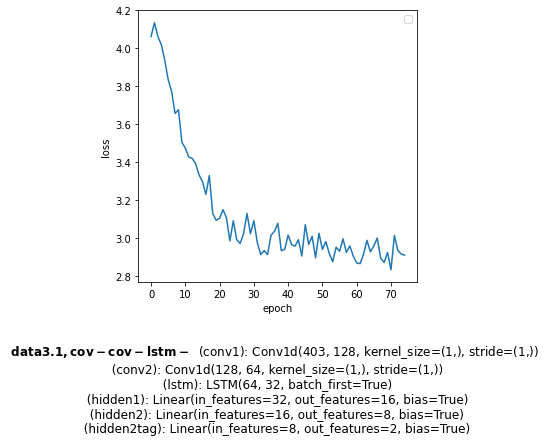

In [ ]:
# loss_list = train(model, data_loader, optimizer, loss_function, epochs=75, early_stopping=False)

_ = loss_plot(loss_list, False, trendline=False)

# Search - loss weight

In [ ]:
# weight_list = torch.tensor(
#     [[0.01, 0.5 ],  # -1.82e-4
#      [0.05, 0.9 ],  # 7.82e-6
#      [0.1,  1.2 ],  # 5.13e-4
#      [0.5,  3.0 ],  # -5.86e-4
#      [0.95, 5.0 ],  # -2.11e-3
#      [1.2,  6.0 ],  # 2.91e-3
#      [1.5,  8.0 ],  # 4.82e-3
#      [1.5,  10.0],  # -8.33e-3
#      [3.0,  10.0]]  # -4.89e-3
# )
# weight_list = torch.tensor(
#     [[0.5,  3.0 ],  # 1.58e-03
#      [0.5,  4.5 ],  # 1.70e-04
#      [0.5,  9.0 ],  # -4.03e-04
#      [1.5,  10.0],  # 2.41e-03
#      [1.5,  15.0],  # 6.06e-03
#      [1.5,  20.0]]  # 4.75e-03
# )
weight_list = torch.tensor(
    [[0.5,  9.0 ],  # 1.56e-03,   -2.36e-03
     [0.2,  9.0 ],  # -1.39e-03,  6.36e-04
     [0.5,  12. ],  # 1.04e-03,   -6.70e-03
     [0.9,  9.0 ],  # -1.21e-02,  -5.25e-03
     [0.9,  12.0]]  # -2.87e-03,  -9.33e-03
)
for w in weight_list:
  loss_function = nn.NLLLoss(w, reduction = 'none') 
  _, loss_list = train(model, data_loader, optimizer, loss_function) # don't actually store the model, just testing loss weights

  m,b = np.polyfit(np.arange(len(loss_list)),torch.Tensor(loss_list), deg=1)
  print(f'''=== w:[{w[0]:.1f}, {w[1]:.0f}] r:{w[1]/w[0]:.1f} ===\n
            m:{m:.2e}\t b:{b:.0f}\t 
            loss endpts:[{loss_list[0]:.1f},{loss_list[-1]:.1f}]''')

  # _ = loss_plot(loss_list, False, f'weights: {w.tolist()}')
  # predictor = Predictor(model, df)
  # predictor.get_metrics()

In [ ]:
_ = loss_plot(loss_list, False, f'weights: {w.tolist()}')

# Results

In [ ]:
# # to change default colormap
# plt.rcParams["image.cmap"] = "Set1"
# to change default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)

In [ ]:
def write_log(exp_n, comment):
    exp = str(exp_n).zfill(3)
    path = 'log/noah/exp' + exp + '/'
    if os.path.exists(path):
        print("=== Overwriting!!! ===")
    else:
        os.makedirs(path)   

    with open("log/noah/log.txt","a") as f:
        f.write('\r\n\r\n' + exp)
        f.write('\r\n\t' + comment)

    dic = {'model':model, 'optim':optimizer}
    torch.save(dic, path +'model_optim.pth')

    print(path)
    return path


In [ ]:
info =  '==== model info ====\n'\
        + 'batchsize=' + str(batch_size)\
        + '\n' + 'optim=' + optimizer.__class__.__name__\
        + '(lr={:g})'.format(optimizer.param_groups[0]['lr'])
print(info)
comment = f"""
data3.1.csv, lr=0.0001, weight{np.array(weight)}, Conv(256,ker=1)-Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2, bc50
""" + info

==== model info ====
batchsize=32
optim=Adam(lr=0.0001)


In [ ]:
exp_nums = re.findall('\d{3}', str(os.listdir('log')))
exp_new = max(list(map(lambda x: int(x), exp_nums))) + 1

In [ ]:
path = write_log(exp_new, comment)

log/exp016/


## Loss

In [ ]:
def loss_plot(loss_list, save=False, title=None, trendline=True):
    losslist = []
    for i in loss_list:
        losslist.append(float(i.detach().numpy()))
    
    xrange = np.arange(len(losslist))
    m,b = np.polyfit(xrange,losslist,1) # obtain trendline

    note = '\n $\mathbf{data3.1, cov-cov-lstm-}$'
    Stitle=note + re.findall('LSTMTagger\(\\n(.+)\\n\)$',str(model), re.S)[0]
    if title is not None:
      Stitle=title+'\n'+Stitle

    fig, axL = plt.subplots(figsize=(5,5))
    fig.suptitle(Stitle, y = -0.001)
    
    axL.plot(losslist)
    axL.set(
        xlabel='epoch',
        ylabel='loss'
    )
    if trendline:
      axL.plot(m*xrange+b,'--', label=f'{m:.2e}x+{b:.0f}')
      axL.legend()
    
    if save:
        plt.savefig(path + 'loss.jpg', bbox_inches='tight')
    
    return losslist
# losslist = loss_plot(loss_list)

In [ ]:
loss_df = pd.DataFrame(losslist)  # .reset_index(drop=False)
loss_df.columns = ['loss']  # ['epoch', 'loss']
loss_df.to_csv(path+'loss.csv', index = False)

In [ ]:
# save
# torch.save(dic, path +'model_optim.pth')
# load
# net = torch.load('.pth')
# net['model'].state_dict()

# Predict

In [ ]:
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc, recall_score, precision_recall_curve, classification_report
import matplotlib.pyplot as plt

all_tags = {0: 0, 1: 1}
pre_batch_size = 1 ###
class Predictor():
    def __init__(self, model, raw_data):
              self.model = model
              self.raw_data = raw_data
    
    def predictor(self):
        """Return a list of part-of-speech tags as strings, one for each word.

        raw_data - a list of (word, tag) pairs.
        """

        with torch.no_grad(): # turns off automatic differentiation, which isn't required but helps save memory

            model.eval()
            loader = df_to_tensor(self.raw_data, batch_size = pre_batch_size, all_label = True, print_summary = False)

            predictions = []
            lgts = []
            for batch in loader:
                feature_seqs, label_seqs, mask_seqs = batch

                seq_len = feature_seqs.shape[1]
                logits = self.model(feature_seqs) 
                output_distribution = logits.reshape(pre_batch_size*seq_len, num_class).tolist()
                index = int(mask_seqs.sum())

                pred = pd.DataFrame(output_distribution[:index]).idxmax(axis=1).tolist()
                predictions += pred
                lgts += logits
            
            self.logits=lgts

            model.train()
            return predictions

    def get_metrics(self):
        self.y_pred = self.predictor()
        self.yBin = self.raw_data['insider']
        report = classification_report(self.yBin, self.y_pred)
        print(report)

        # return report['True']

    # Compute ROC curve and ROC area for each class
    def acu_curve(self, y, prob):
        
        fpr, tpr, threshold = roc_curve(y, prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, 
                tpr, 
                color = 'darkorange',
                lw = 2, 
                label = 'ROC curve (area = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
        plt.xlim([0.0, 1.00])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc = "lower right")
        plt.show()

    def pr_curve(self, y, prob):

        #calculate precision and recall
        precision, recall, thresholds = precision_recall_curve(y, prob)

        #create precision recall curve
        plt.figure(figsize=(10, 10))
        plt.plot(recall, precision, color='purple')

        #add axis labels to plot
        plt.title('Precision-Recall Curve')
        plt.ylabel('Precision')
        plt.xlabel('Recall')

        #display plot
        plt.show()

In [ ]:
# exp0016
predictor = Predictor(model, df)
predictor.get_metrics()
# comment

              precision    recall  f1-score   support

           0       0.85      0.77      0.81     13178
           1       0.15      0.23      0.18      2326

    accuracy                           0.69     15504
   macro avg       0.50      0.50      0.50     15504
weighted avg       0.75      0.69      0.72     15504



NameError: ignored

In [ ]:
# exp0016
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.91      0.65      0.76     16749
           1       0.09      0.34      0.14      1609

    accuracy                           0.62     18358
   macro avg       0.50      0.49      0.45     18358
weighted avg       0.84      0.62      0.71     18358



'\ndata2.1.csv, lr=0.0001, weight[1.5,5],Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2, bc50\n==== model info ====\nbatchsize=32\noptim=Adam(lr=0.0001)'

In [ ]:
# exp0014
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.91      0.45      0.61     16749
           1       0.09      0.53      0.15      1609

    accuracy                           0.46     18358
   macro avg       0.50      0.49      0.38     18358
weighted avg       0.84      0.46      0.57     18358



'\ndata2.1.csv, lr=0.0001, weight[1,6],Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2, bc50\n==== model info ====\nbatchsize=32\noptim=Adam(lr=0.0001)'

In [ ]:
# exp0013
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.91      0.67      0.77     16749
           1       0.08      0.28      0.12      1609

    accuracy                           0.63     18358
   macro avg       0.49      0.47      0.44     18358
weighted avg       0.83      0.63      0.71     18358



'\ndata2.1.csv, lr=0.0001, weight[1,3],Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2, bc50\n==== model info ====\nbatchsize=32\noptim=Adam(lr=0.0001)'

In [ ]:
# exp0012
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.91      0.45      0.60     16749
           1       0.08      0.52      0.14      1609

    accuracy                           0.46     18358
   macro avg       0.49      0.48      0.37     18358
weighted avg       0.83      0.46      0.56     18358



'\ndata2.1.csv, lr=0.0001, weight[0.01,0.99],Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2, bc50\n==== model info ====\nbatchsize=32\noptim=Adam(lr=0.0001)'

In [ ]:
# exp0011
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.91      0.51      0.66     16749
           1       0.09      0.49      0.15      1609

    accuracy                           0.51     18358
   macro avg       0.50      0.50      0.40     18358
weighted avg       0.84      0.51      0.61     18358



'\ndata2.1.csv, lr=0.00001, Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2, bc50\n==== model info ====\nbatchsize=32\noptim=Adam(lr=1e-05)'

In [ ]:
# exp0010
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.99      0.66      0.80     66850
           1       0.00      0.27      0.01       316

    accuracy                           0.66     67166
   macro avg       0.50      0.46      0.40     67166
weighted avg       0.99      0.66      0.79     67166



'\nweek_norm_pca.csv.csv, Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2, bc50\n==== model info ====\nbatchsize=32\noptim=Adam(lr=0.001)'

In [ ]:
# exp009
predictor = Predictor(model, df)
predictor.get_metrics()

              precision    recall  f1-score   support

           0       0.91      0.67      0.77     16749
           1       0.08      0.31      0.13      1609

    accuracy                           0.64     18358
   macro avg       0.50      0.49      0.45     18358
weighted avg       0.84      0.64      0.71     18358



In [ ]:
#exp008
model = torch.load('log/exp008/model_optim.pth')['model']
predictor = Predictor(model, pd.read_csv('data/data_2.1.csv', index_col='idx'))
predictor.get_metrics()

              precision    recall  f1-score   support

           0       0.91      0.66      0.76     16749
           1       0.08      0.32      0.13      1609

    accuracy                           0.63     18358
   macro avg       0.50      0.49      0.45     18358
weighted avg       0.84      0.63      0.71     18358



In [ ]:
# exp007
predictor = Predictor(model, df)
predictor.get_metrics()

              precision    recall  f1-score   support

           0       0.91      0.67      0.77     16749
           1       0.09      0.33      0.14      1609

    accuracy                           0.64     18358
   macro avg       0.50      0.50      0.46     18358
weighted avg       0.84      0.64      0.72     18358



In [ ]:
# pca, no weight loss, batchsize=50
predictor = Predictor(model, df)
predictor.get_metrics()

              precision    recall  f1-score   support

           0       1.00      0.73      0.84     66850
           1       0.00      0.28      0.01       316

    accuracy                           0.73     67166
   macro avg       0.50      0.50      0.43     67166
weighted avg       0.99      0.73      0.84     67166



In [ ]:
# pca, deleted70, no weight loss, batchsize=32
predictor = Predictor(model, df)
predictor.get_metrics()

              precision    recall  f1-score   support

           0       0.99      0.74      0.84     24298
           1       0.01      0.27      0.02       316

    accuracy                           0.73     24614
   macro avg       0.50      0.50      0.43     24614
weighted avg       0.97      0.73      0.83     24614



In [ ]:
# pca, weight loss 0.9,0.1
predictor = Predictor(model, df)
predictor.get_metrics()

              precision    recall  f1-score   support

           0       1.00      0.74      0.85     66850
           1       0.00      0.24      0.01       316

    accuracy                           0.74     67166
   macro avg       0.50      0.49      0.43     67166
weighted avg       0.99      0.74      0.85     67166



In [ ]:
# pca, weight loss 0.1,0.9
predictor = Predictor(model, df)
predictor.get_metrics()
# accuracy so low

              precision    recall  f1-score   support

           0       0.99      0.28      0.44     66850
           1       0.00      0.67      0.01       316

    accuracy                           0.28     67166
   macro avg       0.50      0.48      0.22     67166
weighted avg       0.99      0.28      0.44     67166



In [ ]:
# normall_lstm32_bc32_adam_nll
predictor = Predictor(model, df)
predictor.get_metrics()

              precision    recall  f1-score   support

           0       1.00      0.48      0.64     66850
           1       0.00      0.54      0.01       316

    accuracy                           0.48     67166
   macro avg       0.50      0.51      0.33     67166
weighted avg       0.99      0.48      0.64     67166



In [ ]:
predictor = Predictor(model, df)
predictor.get_metrics()

              precision    recall  f1-score   support

           0       0.98      0.72      0.83      9522
           1       0.03      0.31      0.05       242

    accuracy                           0.71      9764
   macro avg       0.50      0.52      0.44      9764
weighted avg       0.95      0.71      0.81      9764



1. Changed `predict_seqs = predict_seqs.reshape([batch_size,num_class,seq_len])`  
to `predict_seqs = predict_seqs.reshape([-1,num_class,seq_len])`

# （DataLoader.py）

In [ ]:
%%writefile dataloader_.py

import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence,pack_sequence,pad_packed_sequence
from collections import defaultdict
import pandas as pd
from sklearn.model_selection import train_test_split

class MyData(Dataset): 
        def __init__(self, x, y):
            self.feature = x
            self.label = y
        def __len__(self): 
            return len(self.feature)
        def __getitem__(self, idx):
            return (self.feature[idx], self.label[idx])
            
# sequences by user: df to tensor
def df_to_tensor(df, batch_size, all_label, print_summary = False, shuffle = True):
    """
    Args:
        df (DataFrame): sequences(both feature and label) in a DataFrame.
                        must have column 'user'; the last column must be label.
        all_label (bool): output will be the labels of the whole sequence if True,
                          or the label of the last datapoint in the sequence otherwise.
        print_summary (bool, optional): print the size of output.
        shuffle (bool)
    """

    def collate_fn(feature_label): 

        # 第一维是batchsize，所以直接enumerate循环会循环20次
        # feature_label - List:[batchsize个Tuple:(2个Tensor:[maxlen, dimension])] batchsize*2*maxlen*dimension

        features, labels = [], [] # 时间复杂度？？？
        # labels = torch.zeros(len(feature_label), len(feature_label[1][0]))
        for unit in feature_label:
            features.append(unit[0])
            labels.append(unit[1])

        # pad features
        seqs_len = [sequence.size(0) for sequence in features]
        padded_f = pad_sequence(features, batch_first=True, padding_value=0) # 所有sequence补零对齐长度，然后摞在一起
        

        # pad labels
        seqs_len = [sequence.size(0) for sequence in labels]
        padded_l = pad_sequence(labels, batch_first=True, padding_value=0) # 所有sequence补零对齐长度，然后摞在一起

        # masks
        masks = [torch.ones(seq_len) for seq_len in seqs_len]
        padded_m = pad_sequence(masks, batch_first=True, padding_value=0)
        return (padded_f, padded_l, padded_m)

    from collections import defaultdict
    # dic of sequences in df format
    fea_df_dic = defaultdict(pd.DataFrame) # feature seq
    label_df = defaultdict(pd.DataFrame)# label seq
    for user in df.user.unique():
        fea_df_dic[user] = df[df.user == user].iloc[:, 1:-1]
        if all_label:
            # labels are the insider status of all activities in the sequence. [batchsize, maxlength (, 1)]
            label_df[user] = df[df.user == user].iloc[:, -1]
        else:
            # label is the insider status of the last activity in the sequence. [batchsize (, 1, 1)]
            label_df[user] = df[df.user == user].iloc[:, -1].iloc[[-1]]

    # list of features in tensor format (Need to be float32!)
    features = []
    for user, df_i in fea_df_dic.items():
        input_sub = torch.tensor(df_i.values).to(torch.float32)
        features.append(input_sub)
    # list of labels in tensor format (Need to be long!)
    labels = []
    for user, df_i in label_df.items():
        input_sub = torch.tensor(df_i.values).to(torch.long)
        labels.append(input_sub)

    # sequences tensors tuple to Dataset/DataLoader object
    data = MyData(features, labels)
    data_loader = DataLoader(data, batch_size, shuffle=shuffle, collate_fn=collate_fn) 

    if print_summary:
        print("==== DataFrame to DataLoader ====")
        print("Input DataFrame: {}".format(df.shape))
        print("   => {0} sequences ({0} users)".format(len(features)))
        print("       features in size of [(max) length, dimension] = {}".format(features[0].shape))
        print("       labels in size of [(max) length, dimension] = {}".format(labels[0].shape))
        print("   => output DataLoader: {} batches".format(len(data_loader)), "(batchsize = {})".format(batch_size))
        print("       features in size of [batchsize, (max) length, dimension] = {}".format(iter(data_loader).next()[0].shape))
        print("       labels in size of [batchsize, (max) length] = {}".format(iter(data_loader).next()[1].shape))
        print("       masks in size of [batchsize, (max) length] = {}".format(iter(data_loader).next()[2].shape))
    return data_loader

Overwriting dataloader_.py
